In [1]:
2/3

0.6666666666666666

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
from scipy.integrate import odeint
from time import clock, sleep
from datetime import datetime as dt
from pprint import pprint
import pickle
from copy import copy

from pertussis import *

logger.setLevel(logging.INFO)
logger.info("Enter")

# Initial
r_start = 1939
r_end = 2015
step = 1 / N
t_end = expand_time(r_end, start=r_start, step=step)
t_start = expand_time(r_start, start=r_start, step=step)
t_range = np.arange(t_start, t_end, 1)
vars = copy(locals())
times = []
# Data
# report_rate = np.append(nums(250, 7), nums(400, J - 7))  # Danny Cohen paper. pg3
# data_years, years = cases_yearly()  # per 1e5
# data_years *= 400 / 1e5
data, months = cases_monthly()  # per 1e5
# data_months *= 400 / 1e5
# data = cases_month_age()

# Collect State 0 - 1 run of model on year -100 to 0
state_0 = collect_state0()
state_0 = pack_flat(state_0)
warm_up = 100
clk = clock()
state_0 = odeint(hetro_model,state_0, np.arange(0,warm_up*365), args = (4,0,0.1,r_start - warm_up))[-1,:]
logger.info("state_0 collected {:.2f} secs".format(clock() - clk))
# logger.debug("State 0: {}\n".format(state_0))
###################################################################################################################
#########################                            Run Model                   ##################################
###################################################################################################################
import pymc as pm

# Priors
o = pm.Uniform('omega', 3, 6)
phi = pm.Uniform('phi', 0, omega + 0.1)
f_top = 2
f1 = pm.Uniform('f1', 0, f_top)
f2 = pm.Uniform('f2', 0, f_top)
f3 = pm.Uniform('f3', 0, f_top)
# p = pm.Uniform('p', 1 / 400, 1 / 60)
p = SCENARIO[scenario_number]['p']

iterations = 10
iter_now = 0
gclk = clock()
@pm.deterministic
def f(f1=f1, f2=f2, f3=f3):
    return np.concatenate((nums(f1, sc[0]), nums(f2, sc[1]), nums(f3, sc[2])))


# def mu(sim=sim, omega=omega, phi=phi, f=f):
@pm.deterministic
def mu(o=o, phi=phi, f=f):
    # Run simulation
    global iter_now
    iter_now += 1
    clk = clock()
    sim = odeint(hetro_model, pack_flat(state_0), t_range,
                 args=(o, phi, f, r_start))
#     logger.info(" " * 20 + "TIME{:10.2f}".format(clock() - clk))
    progress.warning("{:.2f}".format((100*iter_now) / (iterations*3)))
    with open('./progress.html', 'w') as f:
        f.write("{:.2f}% in {:.2f} Seconds                ({} of about {})".format((100*iter_now) / (iterations*3),
                                                        clock()-gclk,
                                                        iter_now,
                                                                  iterations*3))

    sim = unpack(sim.T, *unpack_values)
#     times.append(clock() - clk)

    # Compute values
    # y is suseptibles. Merge 27 age groupes into 3 susceptible groups
    y = sim[3]
    y = np.split(y, np.cumsum(sc)[:-1])
    y = [yi.sum(axis=0) for yi in y]
    y = np.array([new_cases(yi, gamma_s) for yi in y])
    # TODO: new cases
    # Reduce y to monthly data and take only 1998-2014
    start_ix = (1998 - r_start) * 12
    end_ix = (2014 - r_start) * 12
    res = reduce_month(y)[:, start_ix:end_ix]
    # logger.info(res.shape)
    # logger.info(data.shape)
    return res.T


# print (mu.value)
# Y = pm.Normal('Y', mu=mu1, tau=1 / sigma1 ** 2, observed=True, value=data)
# Y = pm.Binomial('Y', n=mu, p=p, observed=True, value=data.T)
Y = pm.Binomial('Y', n=mu, p=p, observed=True, value=data)

# TODO: Other Backend
# model = pm.Model([Y, sim, f, mu, omega, phi, f1, f2, f3, ])
model = pm.Model([Y, mu, o, phi, f, f1, f2, f3])
mcmc = pm.MCMC(model, db="ram")


mcmc.sample(iter=iterations, burn=0, )  #######################################################################################
logger.info("{} Iterations finished".format(iterations))
logger.info("Global Time {}".format(clock() - gclk))

 [------------------110%-------------------] 11 of 10 complete in 224.4 sec

2

In [ ]:
# More chains
mcmc.sample(iter=4000, burn=0)  #######################################################################################
logger.info("Global Time {}".format(clock() - gclk))

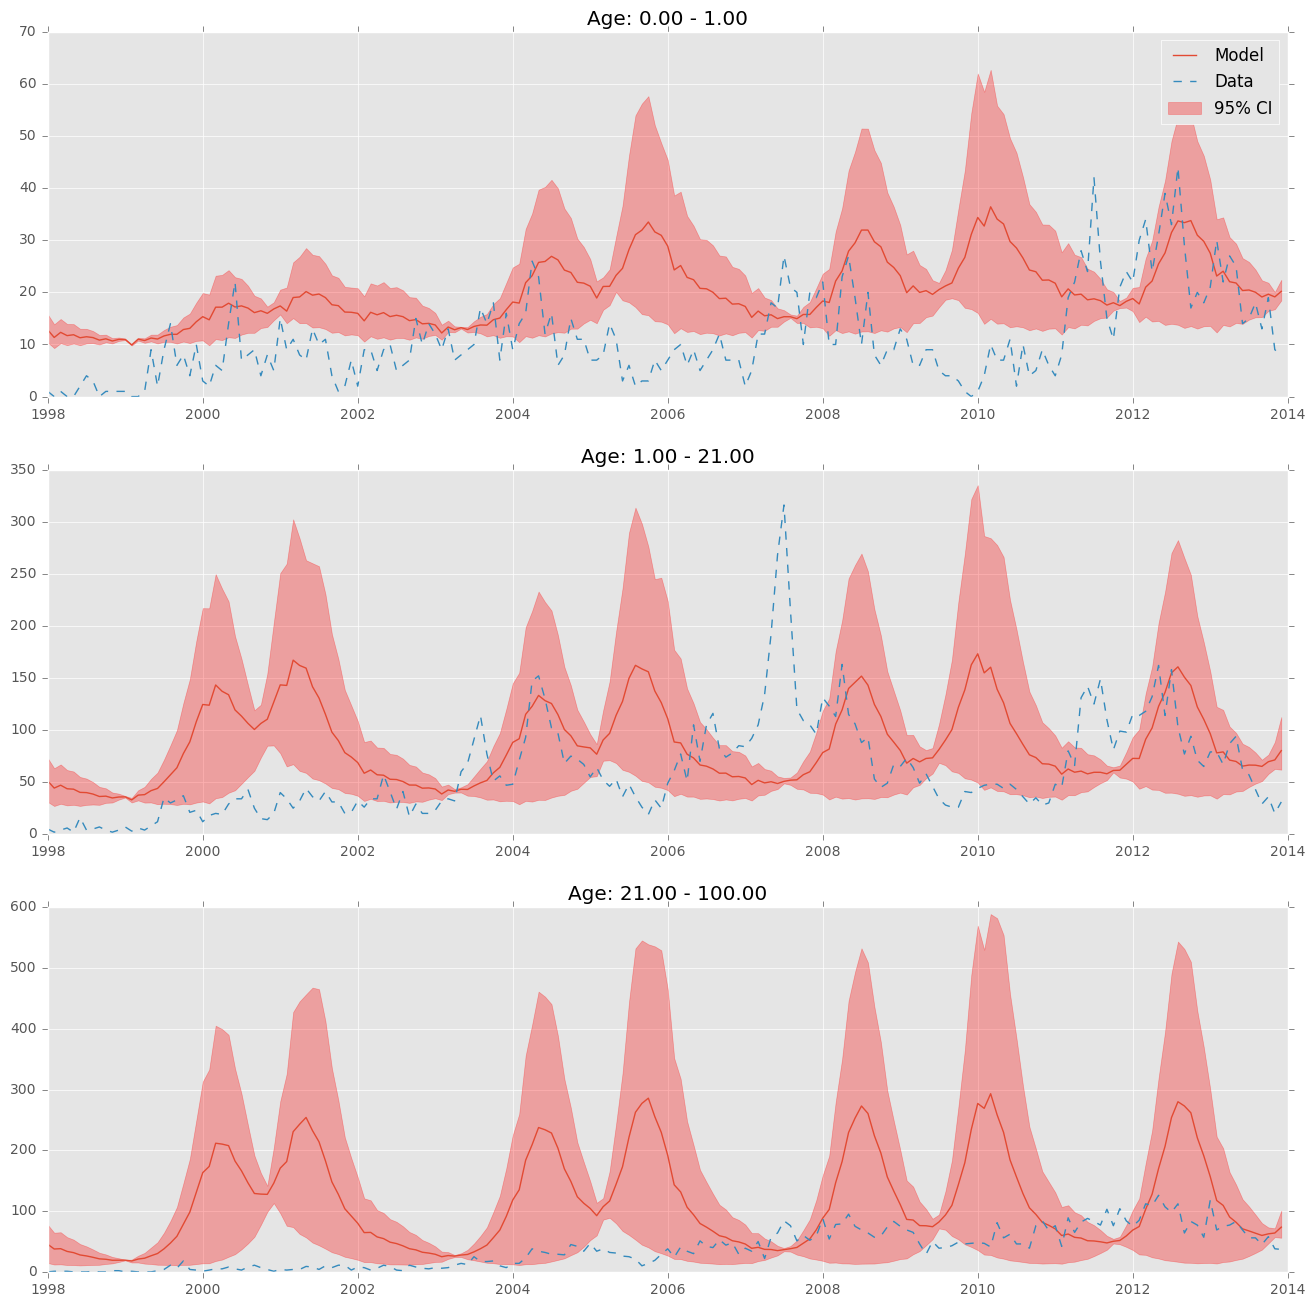

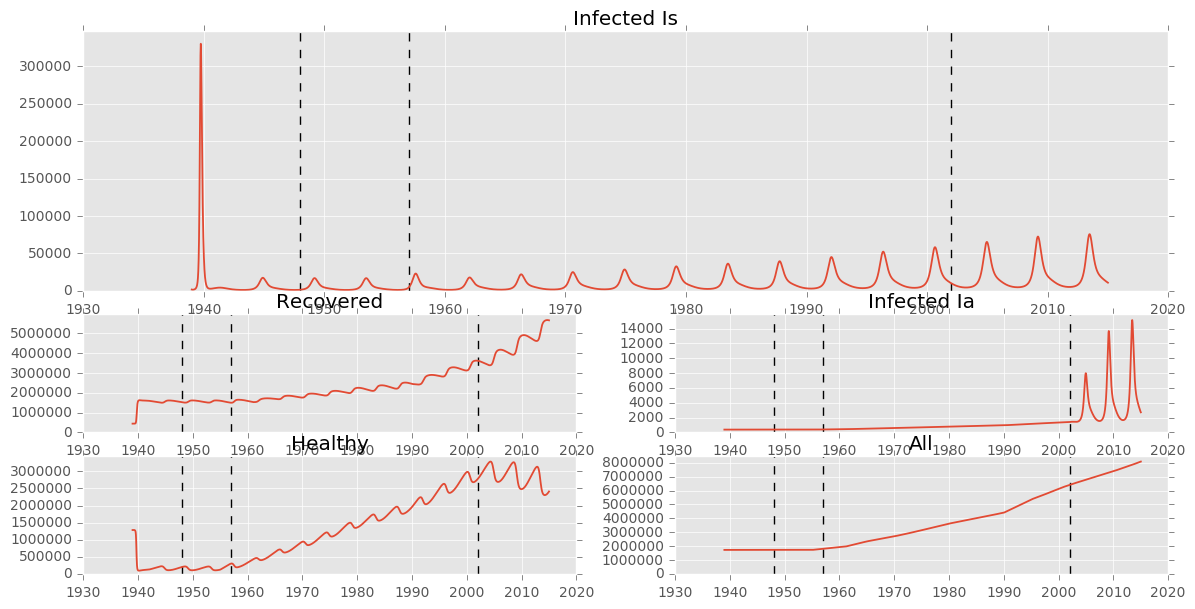

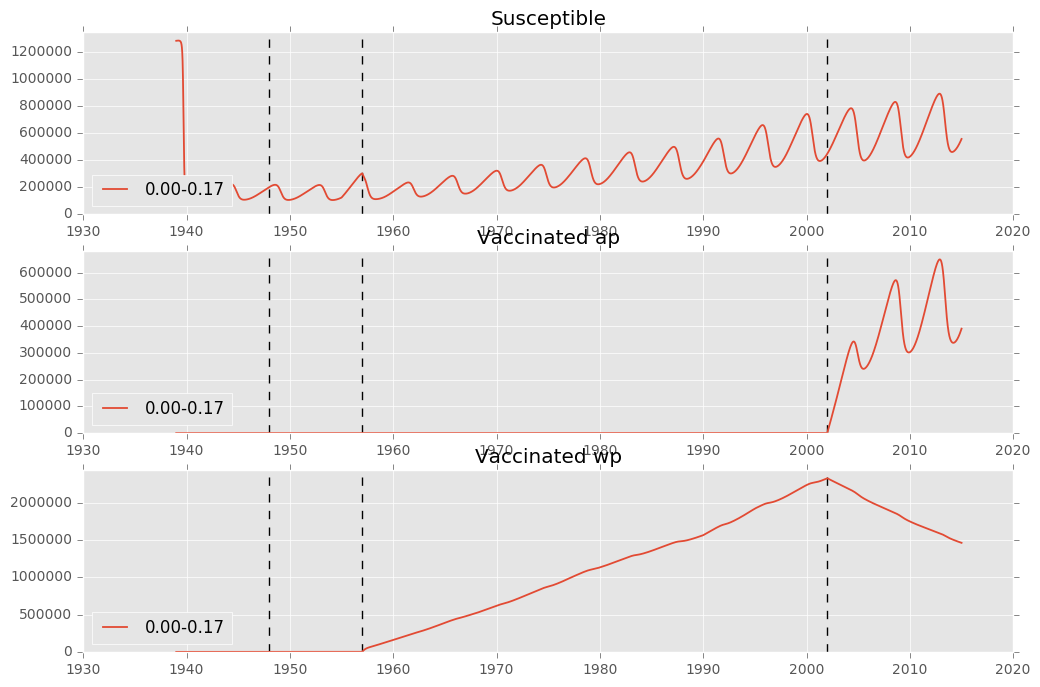

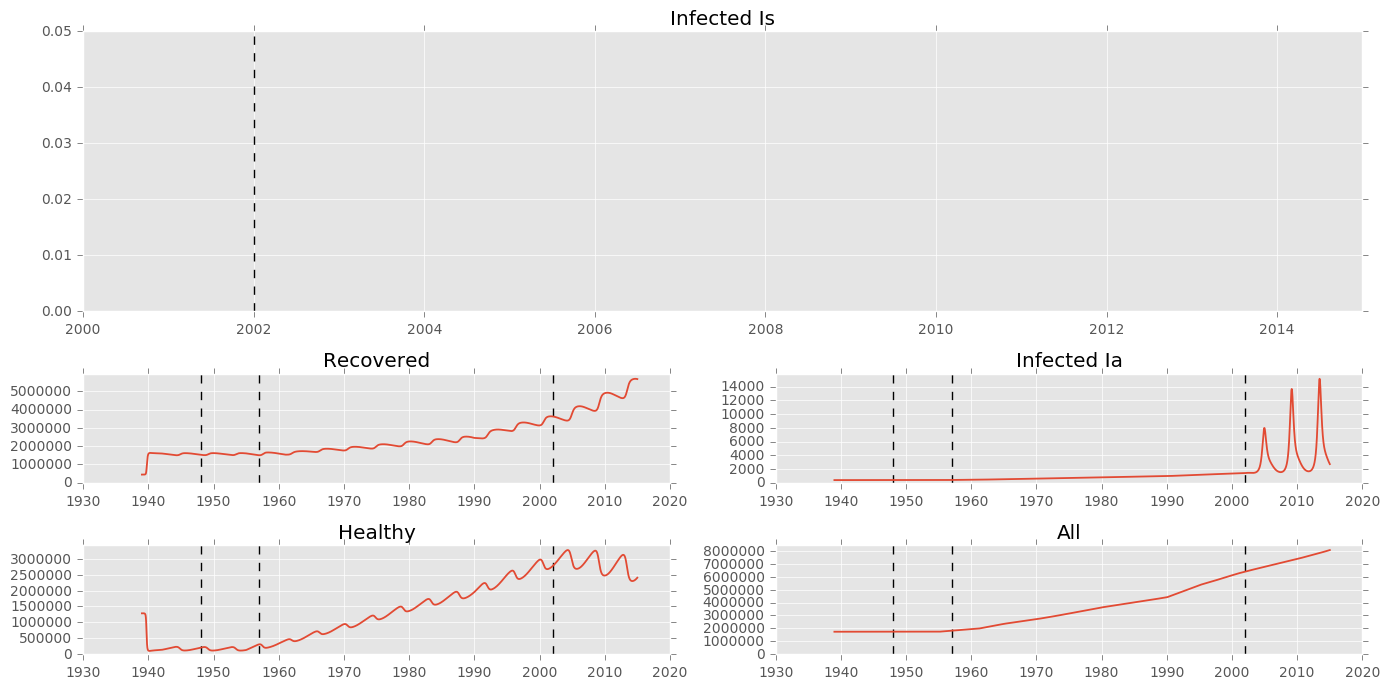

In [3]:
# times = np.array(times)
# logger.info(times.min(), times.mean(), times.max())

# Traces
t_tally = 0
m_f = mcmc.trace('f')[t_tally:].mean(axis=0)
m_omega = mcmc.trace('omega')[t_tally:].mean()
m_phi = mcmc.trace('phi')[t_tally:].mean()
tr_mu = mcmc.trace('mu', chain=None)[t_tally:]
m_mu = tr_mu.mean(axis=0)
# m_p = mcmc.trace('p', chain=None)[t_tally:].mean(axis=0)
m_p = p

# Show mean values fit
clk = clock()
RES = odeint(hetro_model, state_0, t_range,
             args=(m_omega, m_phi, m_f, r_start))
logger.info(" " * 15 +"LAST " + "TIME{:10.2f}".format(clock() - clk))
# # Results
x = reduce_time(t_range, start=r_start, step=step)
y = unpack(RES.T, *unpack_values)
h = sum([i for i in y[:3]])
all = sum([i for i in y])
y.append(h)
y.append(all)


# PLOT
figs = []
fig, axs = mu_chart(tr_mu * m_p, data)
figs.append(fig)

fig1, ax1 = draw_model(x, y[3:], ["Infected Is", "Infected Ia", "Recovered", "Healthy", "All"], split=0, collapse=True)
figs.append(fig1)

fig2, ax2 = draw_model(x, y[0:3], ["Susceptible", "Vaccinated ap", "Vaccinated wp"], split=False, collapse=True)
figs.append(fig2)

fig3, ax3 = draw_model(x, y[3:], ["Infected Is", "Infected Ia", "Recovered", "Healthy", "All"], split=0, collapse=True)
# ax3[0].scatter(years, data_years / 12)
ax3[0].scatter(months, data.sum(axis=1), c='green')
ax3[0].set_xlim([2000, 2015])
ax3[0].set_ylim(0, 0.05)
figs.append(fig3)

plt.tight_layout()
# path = write_report(vars, x, y, figs, scenario_number, mcmc)
# with open (path+"mcmc.pickle", 'wb') as pickle_file:
#     pickle.dump(mcmc.trace(), pickle_file)
# plt.show()
plt.show()

In [9]:
# Save Traces
t_tally = 0
tr_f = mcmc.trace('f')[t_tally:]
tr_f1 = mcmc.trace('f1')[t_tally:]
tr_f2 = mcmc.trace('f2')[t_tally:]
tr_f3 = mcmc.trace('f3')[t_tally:]
tr_omega = mcmc.trace('omega')[t_tally:]
tr_phi = mcmc.trace('phi')[t_tally:]
tr_mu = mcmc.trace('mu', chain=None)[t_tally:]


np.save('./data/traces/tr_f.npy', tr_f)
np.save('./data/traces/tr_f1.npy', tr_f1)
np.save('./data/traces/tr_f2.npy', tr_f2)
np.save('./data/traces/tr_f3.npy', tr_f3)
np.save('./data/traces/tr_omega.npy', tr_omega)
np.save('./data/traces/tr_phi.npy', tr_phi)
np.save('./data/traces/tr_mu.npy', tr_mu)